In [1]:
import os
import sys

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install SmartStockRL package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

    # Clone or update repo.
    repo = "smart-stock-rl"
    repo_url = f"https://github.com/zanderman/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

    # Set dataset root path.
    dataset_root = '~/dataset'

except:
    IN_COLAB = False
    dataset_root = '~/Desktop'
    print('NOT IN COLAB')

# Import package.
import smart_stock as ss

NOT IN COLAB


In [3]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [4]:
# Import other necessary packages after we know that imports are available.
from __future__ import annotations
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

## Dataset

In [5]:
# Request user for Kaggle login if JSON file does not exist.
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) and os.environ.get("KAGGLE_USERNAME",None) is None and os.environ.get("KAGGLE_USERNAME",None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Kaggle Username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:    
        api_key = getpass.getpass(prompt="Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key

    # In Google Colab preserve the login auth across environment restarts.
    if IN_COLAB:
        with open(os.path.expanduser("~/.kaggle/kaggle.json"), 'w') as f:
            json.dump({'username':os.environ["KAGGLE_USERNAME"], 'key':os.environ["KAGGLE_KEY"]}, f)

In [6]:
# Prepare dataset.
stocks = ['aapl', 'nvda', 'dis', 'ko', 'pg']
path = os.path.expanduser(dataset_root)

# This command will download the dataset if it does not exist on the system.
dataset = ss.datasets.HugeStockMarketDataset(path, quiet=False)

## Training Functions

In [7]:
import time
from contextlib import contextmanager

class timecontext:
    """Elapsed time context manager."""
    def __enter__(self):
        self.seconds = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        self.seconds = time.time() - self.seconds

@contextmanager
def timecontextprint(description='Elapsed time'):
    """Context manager to print elapsed time from call."""
    with timecontext() as t:
        yield t
    print(f"{description}: {t.seconds} seconds")

In [8]:
def train(
    agent,
    max_episodes: int = 1000,
    **kwargs,
    ) -> tuple[list[float], bool]:
    """Generic agent training method.

    Specific methods should wrap this one and pass agent-specific arguments
    as keyword arguments.
    """
    # List of reward values for plotting.
    rewards = []

    # Boolean solution flag.
    found_soln = False

    # Episode loop.
    for i in range(max_episodes):
        reward = agent.run_episode(**kwargs)
        rewards.append(reward)
        # if i%100 == 0: print(f'[{i}] {reward}')
        print(f'[{i}] {reward}')

    return rewards, found_soln

In [9]:
def train_QSFM(
    agent: ss.algorithms.qlearning.qsfm.QSFM, 
    max_episodes: int = 1000,
    max_steps: int = None,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train QSFM agent."""
    return train(
        agent=agent,
        max_episodes=max_episodes,
        max_steps=max_steps,
        render=render,
        render_mode=render_mode,
        )

In [10]:
def train_DQN(
    agent: ss.algorithms.deepq.dqn.DQN, 
    max_episodes: int = 1000,
    max_steps: int = None,
    target_update_freq: int = 10,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train DQN agent."""
    return train(
        agent=agent,
        max_episodes=max_episodes,
        max_steps=max_steps, 
        target_update_freq=target_update_freq,
        render=render, 
        render_mode=render_mode,
        )

## Environment

In [11]:
# Create stock environment using specific stock.
df = dataset['aapl']
start_balance = 100
max_stock = 1 # 100
start_day = None
env_name = 'StockDataEnv'
env = ss.envs.StockDataEnv(
    df=df, 
    start_balance=start_balance, 
    max_stock=max_stock, 
    start_day=start_day,
)

In [12]:
# Make runs reproduceable.
RANDOM_SEED = 0 # Turn off by setting as `None`
if RANDOM_SEED is not None:
    env.seed(RANDOM_SEED)
    env.action_space.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

In [13]:
# Set tweakable parameters.
gamma = 0.9 # Discount factor (should be in (0,1)).
alpha = 0.001 # 0.0001 # Step size.
epsilon = 0.2 # Epsilon-greedy action selection (should be in (0,1)).

# Initialize linear function approximator by clipping low/high observation range.
order = 3
obs_low = np.clip(env.observation_space.low, -10, 10)
obs_high = np.clip(env.observation_space.high, -10, 10)
lfa = ss.mapping.fourier.FourierStateFeatureMapping(obs_low, obs_high, order)

# Create Q-learning algorithm agent with LFA.
agent = ss.algorithms.qlearning.qsfm.QSFM(env, lfa, gamma, alpha, epsilon)

[0] 0.03625806248176984
[1] 0.04058707134408499
[2] 0.0548873702003142
[3] 0.05121434957875228
[4] 0.04930293816572326
[5] 0.04955961951626455
[6] 0.048543621986533086
[7] -0.007555626465430801
[8] 0.04896646353921939
[9] 0.05006827497464335
[10] 0.046939898581517314
[11] 0.0506365259535352
[12] 0.004678982220697701
[13] 0.04449299555337086
[14] 0.04888791420354147
[15] 0.04871136470977121
[16] 0.06737947728576453
[17] 0.04945888167665711
[18] 0.053659707414659655
[19] 0.046714616123454115
[20] 0.04626200905475243
[21] 0.048828125
[22] 0.04842378832960023
[23] 0.050040563721529485
[24] 0.04946753615214057
[25] 0.0469938427277544
[26] 0.048649354528708465
[27] 0.05226193973001954
[28] 0.04741779587851165
[29] 0.05045494404115658
[30] 0.050258364642381564
[31] 0.05120274357635195
[32] 0.050366205757683746
[33] 0.04900924054637952
[34] 0.048828125
[35] 0.052443730416274766
[36] 0.05108372884143593
[37] 0.04786740244956053
[38] 0.04991702737286255
[39] 0.06110096177196567
[40] 0.0485098013

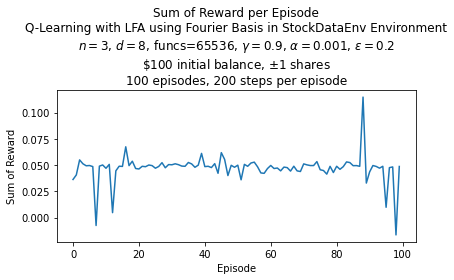

In [15]:
max_episodes = 100 # 1000 # Upper-limit on number of possible episodes.
max_steps = 200
render = False
render_mode = 'csv'

# Train the agent 
with timecontextprint():
    rewards, found_soln = train_QSFM(agent, max_episodes, max_steps, render, render_mode)

# Plot the rewards.
plt.figure()
plt.plot(rewards)
plt.title(f"Sum of Reward per Episode\nQ-Learning with LFA using Fourier Basis in {env_name} Environment\n$n={order}$, $d={obs_low.size}$, funcs={lfa.coeffs.shape[0]}, $\gamma={gamma}$, $\\alpha={alpha}$, $\epsilon={epsilon}$\n\${start_balance} initial balance, $\pm${max_stock} shares\n{max_episodes} episodes, {max_steps} steps per episode")
plt.xlabel('Episode')
plt.ylabel('Sum of Reward')
plt.tight_layout()
plt.show()